# Simple Power Plant Modeling
-----------------------------------

_[GPkit](https://github.com/appliedopt/gpkit) for model representation and solver interfacing._

### Design objective

An airplane with that consumes as little fuel as possible when cruising (while remaining capable of taking off from the ground, with wings that won't break, etc.)

### To Do

abstract kelvin
http://pint.readthedocs.io/en/0.7.2/nonmult.html?highlight=temperature
need to figure out how to convert celsius to kelvin in Variable

get dollar working

figure out how to plot swept variables. not just constants.
and how to see outputs for variables that are hidden behind free variables (like C_fueltot)

check that model well represents their sheet.
yes, except for weird variable lifetime thing.
and evrelse costs may be a little higher and operational personnel, and dependent on refueling time if graphite is replaced.
can you do toggles like that? replacing or not?

reinstall environment to get controlpanel working



## 1. Set up the modeling environment

Start by importing Numpy and GPkit, and turning on LaTex printing for GPkit variables and equations:

In [1]:
import ipywidgets
print ipywidgets.__version__

import numpy as np
import gpkit
import gpkit.interactive

5.1.5


In [2]:
import IPython
print IPython.__version__

5.3.0


In [3]:
from pint import UnitRegistry
ureg = UnitRegistry()
ureg.define('dollar = [] = $')      # defining a dimensionless reference unit dollar

Next declare constants (including take-off and cruising speed, which will be 'swept' over a range of values):

In [4]:
# V = gpkit.Variable("V", ("sweep", np.linspace(45, 55, 5)), "m/s", "cruising speed")  # sweep and autosweep dont work well together
# V = gpkit.Variable("V", 50, "m/s", "cruising speed")
# T_aC = gpkit.Variable("T_{aC}", 40, "C", "ambient temperature")
# T_aC = 40 + 273
T_a = gpkit.Variable("T_{a}", 313, "degK", "ambient temperature")
pi = gpkit.Variable("\\pi", np.pi, "-", "half of the circle constant")
C_BoP = gpkit.Variable("C_{BoP}", 5e6, "-", "cost of balance of plant")  # pint doesn't like $ unit?
C_fusion = gpkit.Variable("C_{fusion}", 8e6, "-", "cost of balance of plant")
C_fuel = gpkit.Variable("C_{fuel}", 200, "1/kg", "price of fuel")   # this will also accept different units (e.g. kg or g)
# P_pin = gpkit.Variable("P_{pin}", 3, "kW", "power per pin")     # this is actually not a constant 
t_life = gpkit.Variable("t_{life}", 20, "year", "expected plant lifetime")
P_fus = gpkit.Variable("P_{fus}", 1, "MW", "electric power required to run fusion")
eta_frac = gpkit.Variable("\\eta_{frac}", 0.7, "-", "fraction of carnot efficiency achieved")


Then declare the rest of the variables (there's no need to separate variables and constants like this, I just find it a little more readable):

In [5]:
eta = gpkit.Variable("\\eta", "-", "plant ideal carnot efficiency")
P_e = gpkit.Variable("P_{e}", "MW", "plant electric power to grid, after fusion")
P_th = gpkit.Variable("P_{th}", "MW", "core thermal power")
T_c = gpkit.Variable("T_{c}", "degK", "turbine cold temperature")
T_h = gpkit.Variable("T_{h}", "degK", "turbine hot inlet temperature")
DT = gpkit.Variable("DT", "degK", "delta temperature")
Rev_elec = gpkit.Variable("Rev_{elec}", "-", "revenue from electricity")
C_refuel = gpkit.Variable("C_{refuel}", "-", "cost of refuel")  # cost of a new core's worth of fuel
C_fueltot = gpkit.Variable("C_{fuel_tot}", "-", "total cost of fuel over lifetime")
C_evrelse = gpkit.Variable("C_{evrelse}", "-", "cost of core besides fuel")
C_tot = gpkit.Variable("C_{tot}", "-", "total plant cost")
C_elec = gpkit.Variable("C_{elec}", "1/(kW*hr)", "price of electricity")
m_fuel = gpkit.Variable("m_{fuel}", "tonne", "fuel mass")    # metric ton = 1000kg
n_pins = gpkit.Variable("n_{pins}", "-", "number of pins")
m_pin = gpkit.Variable("m_{pin}", "kg", "mass per pin") 
t_refuel = gpkit.Variable("t_{refuel}", "year", "time between refueling")


## 1.5. Fit a function to data

In [6]:
from gpfit.fit import fit
from numpy import logspace, log, log10, random

[19 19 19 19 19 19 28 28 28 28 28 28 39 39 39 39 39 39]
[15 16 17 18 19 20 15 16 17 18 19 20 15 16 17 18 19 20]
[  5.    4.    4.    3.    2.    0.1   9.    8.    7.    6.    4.5   1.5
  11.    9.    8.    7.    5.    2.5]


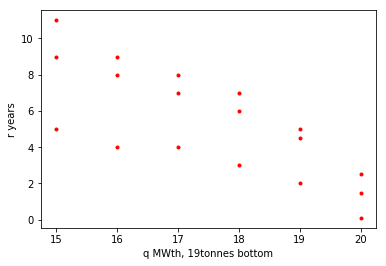

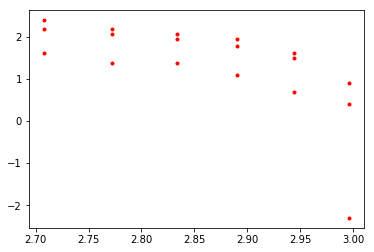

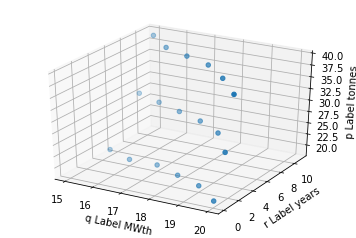

In [7]:


#HAMSTR 6m design neutronics simulations from Matthew 7/12/17:

p = np.array([19, 19, 19, 19, 19, 19, 28, 28, 28, 28, 28, 28, 39, 39, 39, 39, 39, 39])  # "fuel mass, ton"
print p
q = np.array([15, 16, 17, 18, 19, 20, 15, 16, 17, 18, 19, 20, 15, 16, 17, 18, 19, 20])  # "power, MWth"
print q
r = np.array([5, 4, 4, 3, 2, 0.1, 9, 8, 7, 6, 4.5, 1.5, 11, 9, 8, 7, 5, 2.5])  # "time between refueling, years"
# changed some values. nicely convex: [5, 4.6, 4, 3.1, 2, 0.1, 9, 8.3, 7.2, 6, 4.5, 1.5, 10, 9.3, 8.3, 7, 5, 2.5]
# doesn't actually seem to help much, in fitting at least
# original: [5, 4, 4, 3, 2, 0.1, 9, 8, 7, 6, 4.5, 1.5, 11, 9, 8, 7, 5, 2.5]
print r


import matplotlib.pyplot as plt
plt.plot(q, r, 'r.')
# plt.axis([14, 21, 0, 20])
plt.xlabel('q MWth, 19tonnes bottom')
plt.ylabel('r years')
plt.show()

m = log(q)
n = log(r)
plt.plot(m, n, 'r.')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(q, r, p)
ax.set_xlabel('q Label MWth')
ax.set_ylabel('r Label years')
ax.set_zlabel('p Label tonnes')
plt.show()




In [8]:

u = np.array([q, r])      # [MWth, years]
print u
w = p                     # [tons]
print w


x = log(u)
y = log(w)
print x
print y

    
K=2     # what is this?  higher means a closer fit?  kinda. I think just number of fitting curves (terms) allowed
        # can't get above K=3 without getting too large or small of a coefficient. are my data points that bad?

# fixed initial guess for fitting. so it's not different every time
random.seed(33404)
    
    
cMA, errorMA = fit(x, y, K, "MA")  
print "MA RMS Error: %.5g" % errorMA

cSMA, errorSMA = fit(x, y, K, "SMA")               # after choosing p as dependent, now off by 0.01 to 0.09
print "SMA RMS Error: %.5g" % errorSMA              

                                                    #u_1 is MWth, u_2 is years, w is tons

#cISMA, errorISMA = fit(x, y, K, "ISMA")     
#print "ISMA RMS Error: %.5g" % errorISMA
                                                    # these errors dont seem right. plugged ind. variable data
                                                    # back into the function and got outputs off by 0.1 to 0.5
                                                    # 
            
print cMA
cMA

#gpkit.FitCS(cSMA, errorSMA)
    
print cSMA
cSMA

#simplecSMA = cSMA * m_(fac--fit)**0.29

#simplecSMA


                                        # need to figure out how to use this output function in the model
                                        # something about this Fit(CS)

[[ 15.   16.   17.   18.   19.   20.   15.   16.   17.   18.   19.   20.
   15.   16.   17.   18.   19.   20. ]
 [  5.    4.    4.    3.    2.    0.1   9.    8.    7.    6.    4.5   1.5
   11.    9.    8.    7.    5.    2.5]]
[19 19 19 19 19 19 28 28 28 28 28 28 39 39 39 39 39 39]
[[ 2.7080502   2.77258872  2.83321334  2.89037176  2.94443898  2.99573227
   2.7080502   2.77258872  2.83321334  2.89037176  2.94443898  2.99573227
   2.7080502   2.77258872  2.83321334  2.89037176  2.94443898  2.99573227]
 [ 1.60943791  1.38629436  1.38629436  1.09861229  0.69314718 -2.30258509
   2.19722458  2.07944154  1.94591015  1.79175947  1.5040774   0.40546511
   2.39789527  2.19722458  2.07944154  1.94591015  1.60943791  0.91629073]]
[ 2.94443898  2.94443898  2.94443898  2.94443898  2.94443898  2.94443898
  3.33220451  3.33220451  3.33220451  3.33220451  3.33220451  3.33220451
  3.66356165  3.66356165  3.66356165  3.66356165  3.66356165  3.66356165]
w = 42.253 * (u_1)**-0.248723 * (u_2)**0.106129
w =

gpkit.FitCS(
        m_{fac--fit}**-0.066*w_fit.1**0.066 >= 0.853*u_fit.1_(0,)**0.098*u_fit.1_(1,)**0.055 + 1.3e-24*u_fit.1_(0,)**18*u_fit.1_(1,)**-0.35)

## 2. Write the system's equations

The drag and wing-weight models consist of several sub-models, so we'll write them here for convenience:

In [9]:
equations = []

equations += [ gpkit.units.t**-0.0655414*m_fuel**0.0655414 >= (gpkit.units.MW**-0.0975763 * 0.852883 * P_th**0.0975763) * (gpkit.units.year**-0.0545444 * t_refuel**0.0545444) 
              + (gpkit.units.MW**-17.5623 * 1.29849e-24 * P_th**17.5623) * (gpkit.units.year**0.349478 * t_refuel**-0.349478)  
             ]
                # K=3 gpkit.units.t**-0.161536*m_fuel**0.161536 >= (gpkit.units.MW**-8.2996 * 1.10577e-14 * P_th**8.2996) * (gpkit.units.year**-3.41647 * t_refuel**3.41647) + (gpkit.units.MW**0.094043 * 2.08871 * P_th**-0.094043) * (gpkit.units.year**0.00755758 * t_refuel**-0.00755758) 
                # how do we treat units for an imported fit?  just cancel all the units
                # gpkit.units.t**-0.0655414*
                # gpkit.units.W**-0.0975763 * 
                # gpkit.units.year**-0.0545444 * 
                # result is very sensitive to exponent rounding - looks like the solver is rounding to 3 decimal places
                # for wolframalpha: solve  w**0.066 = 0.8529 * (u_1)**0.098 * (u_2)**0.055, u_1=16, u_2=0.9
                # only monomials can use ==
                # coefficient may be tiny, but exponent may be big too, to compensate
equations

[gpkit.PosynomialInequality(m_{fuel}**0.066 >= 0.853*P_{th}**0.098*t_{refuel}**0.055 + 1.3e-24*P_{th}**18*t_{refuel}**-0.35)]

In [10]:


# T_a  = T_aC + 273*gpkit.units.C
T_c = T_a + 20*gpkit.units.degK                  # ambient temp standoff 
# P_th = P_fuel*m_fuel                       # P_th is not dependent on mass of fuel
equations += [ P_e + P_fus <= eta*eta_frac*P_th,
               1 >= eta + T_c/T_h    ]

C_refuel = C_fuel*m_fuel
print type(C_refuel)
C_fueltot = C_refuel*(t_life/t_refuel)
C_evrelse =  m_fuel*0.89e6/gpkit.units.t    # simplifying by saying this is proportional to fuel mass (m_fuel). accurate
C_tot = C_fueltot + C_evrelse + C_BoP + C_fusion    # total capex plus fuel over plant lifetime
print type(C_tot)
equations += [  
                C_elec >= C_tot/(P_e*t_life)     # cost of electricity from plant over its lifetime
             ]
                      
equations += [
              m_fuel >= 19*gpkit.units.tonne,
#              P_th <= 20*gpkit.units.MW,
              T_h <= 800*gpkit.units.degK,
             ]               


# add bounds. algebraic manipulations to get it into acceptable form are typical
  

<class 'gpkit.nomials.nomial_math.Monomial'>
<class 'gpkit.nomials.nomial_math.Posynomial'>


In [11]:
m = gpkit.Model(C_elec,         # Minimize total plant cost
                equations)     # subject to our model

In [12]:
m

gpkit.Model(
  # minimize
        C_{elec}
  # subject to
        m_{fuel}**0.066 >= 0.853*P_{th}**0.098*t_{refuel}**0.055 + 1.3e-24*P_{th}**18*t_{refuel}**-0.35
        P_{th}*\eta*\eta_{frac} >= P_{e} + P_{fus}
        20*T_{h}**-1 + T_{a}*T_{h}**-1 + \eta <= 1
        C_{elec} >= 1e+03*C_{fuel}*P_{e}**-1*m_{fuel}*t_{refuel}**-1 + 8.9e+05*P_{e}**-1*m_{fuel}*t_{life}**-1 + C_{BoP}*P_{e}**-1*t_{life}**-1 + C_{fusion}*P_{e}**-1*t_{life}**-1
        m_{fuel} >= 19
        T_{h} <= 800)

## 3. Solve the system

In [13]:
data = m.solve()
print data.table()

Using solver 'cvxopt'
Solving for 7 variables.
Solving took 1.53 seconds.

Cost
----
 0.04782 [1/hr/kW] 

Free Variables
--------------
  C_{elec} : 0.04782  [1/hr/kW] price of electricity
     P_{e} : 6.004    [MW]      plant electric power to grid, after fusion
    P_{th} : 17.14    [MW]      core thermal power
     T_{h} : 800      [K]       turbine hot inlet temperature
      \eta : 0.5838             plant ideal carnot efficiency
  m_{fuel} : 19       [t]       fuel mass
t_{refuel} : 3.721    [year]    time between refueling

Constants
---------
    C_{BoP} : 5e+06         cost of balance of plant
   C_{fuel} : 200    [1/kg] price of fuel
 C_{fusion} : 8e+06         cost of balance of plant
    P_{fus} : 1      [MW]   electric power required to run fusion
      T_{a} : 313    [K]    ambient temperature
\eta_{frac} : 0.7           fraction of carnot efficiency achieved
   t_{life} : 20     [year] expected plant lifetime

Sensitivities
-------------
\eta_{frac} : -1.2   fraction of 

In [14]:
%matplotlib inline         
# optional, displays plots in notebook
%config InlineBackend.figure_format = 'retina'   
# start up the iPython Notebook plotting environment



m.controlpanel([C_fuel, T_a, C_BoP, C_fusion, t_life])  # currently broken due to ipywidgets 6.0.0 update
                                            # now working with old versions.
                                            # had to comment out autosweeps to get control panel sliders to work
                                            # sliders only work for constants? can I slide
                                            # , eta, m_fuel, T_h, P_e     not these

#m.autosweep({C_fuel: (180, 220)}, tol=0.0001, verbosity=0).plot()
#m.autosweep({T_a: (293, 313)}, tol=0.001).plot()  # variable inside plot() is y axis, default is cost
                                                    # need to specify range for plot because it is solving the 
                                                    # whole model for this range
#m.autosweep({C_fuel: (130, 220)}, tol=0.001, verbosity=0).plot(P_th)
#m.autosweep({C_fuel: (130, 220)}, tol=0.001, verbosity=0).plot(t_refuel)
#m.autosweep({m_fuel: (19, 50)}, tol=0.0001, verbosity=0).plot(C_fueltot)
#m.autosweep({m_fuel: (19, 50)}, tol=0.0001, verbosity=0).plot(C_evrelse)



#m.interactive([C_fuel, T_a, eta, m_fuel])   # currently broken due to ipywidgets 6.0.0 update. 
                                            # still doesnt work, even running ipywidgets 5.1.5 and ipython 5.3.0


Cost
----
 0.04924 [1/hr/kW] 

Free Variables
--------------
  C_{elec} : 0.04924  [1/hr/kW] price of electricity
     P_{e} : 6.026    [MW]      plant electric power to grid, after fusion
    P_{th} : 17.19    [MW]      core thermal power
     T_{h} : 800      [K]       turbine hot inlet temperature
      \eta : 0.5838             plant ideal carnot efficiency
  m_{fuel} : 19       [t]       fuel mass
t_{refuel} : 3.687    [year]    time between refueling

Most Sensitive
--------------
\eta_{frac} : -1.2  fraction of carnot efficiency achieved
      T_{a} : +0.78 ambient temperature
   t_{life} : -0.6  expected plant lifetime
   C_{fuel} : +0.4  price of fuel
 C_{fusion} : +0.18 cost of balance of plant



C_tot = C_fueltot + C_evrelse + C_BoP + C_fusion

at 19 tonnes of fuel mass, C_tot = 20 + 17 + 5 + 8 = 50

yep, checks out

so fuel cost seems to be dominating

In [15]:
#gpkit.interactive.plotting.plot_frontiers(m, [eta, m_fuel], 1, 3, (5,5))  # currently broken due to ipywidgets 6.0.0 update

In [16]:
#from gpkit.interactive.plotting import sensitivity_plot   # cant import sensitivity_plot?
#fig = sensitivity_plot(m, yxmax=0.75)
#plt.show()